# EKF Localization

In [92]:
%matplotlib inline

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys

# matplotlib.style.use('ggplot')
matplotlib.style.use('default')

In [93]:
from google.colab import drive
drive.mount("/content/drive/")
sys.path.append("/content/drive/My Drive/Colab Notebooks/EKF")
!ls "/content/drive/My Drive/Colab Notebooks/EKF"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
ls: cannot access '/content/drive/My Drive/Colab Notebooks/EKF': No such file or directory


## Introduction

This coursework is about simulation of robot localizaion problem based on extended kalman filter (EKF).


In this simulation, the robot has a state vector which includes 4 states at time t,
$\textbf{x}_t=[x_t, y_t, \phi_t, v_t]$
where
$x_t$, $y_t$ are a 2D x-y position, $\phi_t$ is orientation (yaw angle), and $v_t$ is velocity. Covariace matrix of the state is given by $\textbf{P}_t$.  The initial state covariance matrix at time t = 0 can be given as

\begin{equation*} \mathbf P_0 = \begin{bmatrix} \sigma^2_{p_x} & 0 & 0 & 0 \\ 0 & \sigma^2_{p_y} & 0 & 0 \\ 0 & 0 & \sigma^2_{p_\phi} & 0 \\ 0 & 0 & 0 & \sigma^2_{p_v} \end{bmatrix} \end{equation*}

where $\sigma^2$ is a variance.



The robot has a Speed sensor and a Gyro sensor i.e. sensor fusion. So, the control input vector can be used at each
time step t,
$\textbf{u}_t=[v_t, \omega_t]$
where $v_t$ is velocity and $\omega_t$ (pronounced as omega_t) is angular velocity (yaw rate).

Also, the robot has a Global Navigation Satellite System (GNSS) sensor. This means that the robot can observe x-y
position at each time t.
$\textbf{z}_t=[x_t,y_t]$

The control input vector and observation vector include their corresponding sensor noise. Hence, we consider additive Gaussian noise.


## Process Model

We model the process or system as a non-linear robot motion model plus a noise.

$\textbf{x}_{t+1} = f(\textbf{x}_t, \textbf{u}_t) + w_x$

where $w_x$ is a zero-mean Gaussian white noise with covariance matrix $\textbf{Q}$ i.e. $w_x = \mathcal{N} (0, \textbf{Q})$. The process noise covariance matrix $\textbf{Q}$ can be given as

\begin{equation*} \mathbf Q = \begin{bmatrix} \sigma^2_{q_x} & 0 & 0 & 0 \\ 0 & \sigma^2_{q_y} & 0 & 0 \\ 0 & 0 & \sigma^2_{q_\phi} & 0 \\ 0 & 0 & 0 & \sigma^2_{q_v} \end{bmatrix} \end{equation*}


The non-linear robot motion function is given as

\begin{equation*} \begin{bmatrix} x' \\ y' \\ \phi' \\ v' \end{bmatrix} = f(\textbf{x}, \textbf{u}) = \begin{bmatrix} x + v\cos(\phi)\Delta t \\ y + v\sin(\phi)\Delta t \\ \phi + \omega \Delta t \\ v \end{bmatrix} \end{equation*}

$\Delta_t$ is a time interval. Note that $v$ is the velocity from the control input.


The Jacobian matrix of $f$ is


\begin{equation*} J_f = \frac{\partial f(\mathbf x, \mathbf u)}{\partial \mathbf x} = \begin{bmatrix} \frac{\partial f_1}{\partial x_1}& \frac{\partial f_1}{\partial x_2} & \frac{\partial f_1}{\partial x_3} & \frac{\partial f_1}{\partial x_4}\\ \frac{\partial f_2}{\partial x_1}& \frac{\partial f_2}{\partial x_2} & \frac{\partial f_2}{\partial x_3} & \frac{\partial f_2}{\partial x_4}\\ \frac{\partial f_3}{\partial x_1}& \frac{\partial f_3}{\partial x_2} & \frac{\partial f_3}{\partial x_3} & \frac{\partial f_3}{\partial x_4}\\ \frac{\partial f_4}{\partial x_1}& \frac{\partial f_4}{\partial x_2} & \frac{\partial f_4}{\partial x_3} & \frac{\partial f_4}{\partial x_4} \end{bmatrix} \end{equation*}

\begin{equation*} = \begin{bmatrix} \frac{\partial x'}{\partial x}& \frac{\partial x'}{\partial y} & \frac{\partial x'}{\partial \phi} & \frac{\partial x'}{\partial v}\\ \frac{\partial y'}{\partial x}& \frac{\partial y'}{\partial y} & \frac{\partial y'}{\partial \phi} & \frac{\partial y'}{\partial v}\\ \frac{\partial \phi'}{\partial x}& \frac{\partial \phi'}{\partial y} & \frac{\partial \phi'}{\partial \phi} & \frac{\partial \phi'}{\partial v}\\ \frac{\partial v'}{\partial x}& \frac{\partial v'}{\partial y} & \frac{\partial v'}{\partial \phi} & \frac{\partial v'}{\partial v} \end{bmatrix} \end{equation*}


\begin{equation*} = \begin{bmatrix} 1& 0 & -v \sin(\phi) \Delta t & \cos(\phi) \Delta t\\ 0 & 1 & v \cos(\phi) \Delta t & \sin(\phi) \Delta t\\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \end{equation*}

<!-- \begin{equation*} = \begin{bmatrix} &  &  &  \\
                                    &  &  &  \\
                                    &  &  &  \\
                                    &  &  &  \end{bmatrix} \end{equation*} -->

\\

Note that the state transition matrix $\mathbf F$ is given as

$$
\begin{aligned}
\mathbf F
&= {\frac{\partial{f(\mathbf x, \mathbf u)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}} \\
\end{aligned}
$$

## Observation Model

The robot can get x-y position infomation from GPS (GNSS).

So GPS or GNSS Observation model is given by

$\textbf{z}_{t} = h(\textbf{x}_t) + w_z$

where $w_z$ is a zero-mean Gaussian white noise with covariance matrix $\textbf{R}$ i.e. $w_z = \mathcal{N} (0, \textbf{R})$. The observation noise covariance matrix $\textbf{R}$ can be given as

\begin{equation*} \mathbf R = \begin{bmatrix} \sigma^2_{r_x} & 0  \\ 0 & \sigma^2_{r_y} \end{bmatrix} \end{equation*}


The observation function is given as

\begin{equation*} \begin{bmatrix} x' \\ y' \end{bmatrix} = h(\textbf{x}) = \begin{bmatrix} x \\ y \end{bmatrix} \end{equation*}

The Jacobian matrix of $h$ is

\begin{equation*} J_h =  \frac{\partial h(\mathbf x)}{\partial \mathbf x} = \begin{bmatrix} \frac{\partial h_1}{\partial x_1} & \frac{\partial h_1}{\partial x_2} & \frac{\partial h_1}{\partial x_3} & \frac{\partial h_1}{\partial x_4}\\ \frac{\partial h_2}{\partial x_1}& \frac{\partial h_2}{\partial x_2} & \frac{\partial h_2}{\partial x_3} & \frac{\partial h_2}{ \partial x_4}\\ \end{bmatrix} \end{equation*}

\begin{equation*} = \begin{bmatrix} \frac{\partial x'}{\partial x} & \frac{\partial x'}{\partial y} & \frac{\partial x'}{\partial \phi} & \frac{\partial x'}{\partial v}\\ \frac{\partial y'}{\partial x}& \frac{\partial y'}{\partial y} & \frac{\partial y'}{\partial \phi} & \frac{\partial y'}{ \partial v}\\ \end{bmatrix} \end{equation*}

\begin{equation*} = \begin{bmatrix} 1& 0 & 0 & 0\\ 0 & 1 & 0 & 0\\ \end{bmatrix} \end{equation*}

<!-- \begin{equation*} = \begin{bmatrix}   &  &   &  \\
                                      &  &   &  \\ \end{bmatrix} \end{equation*} -->


\\
Note that the measurement matrix $\mathbf H$ which maps the state space into the observation space is given as

$$
\begin{aligned}
\mathbf H &= \frac{\partial{h(\mathbf x})}{\partial{\mathbf x}}\biggr|_{\mathbf x_t}
\end{aligned}
$$


## EKF Algorithm

The EKF algorithm based on the above motion and observation functions can be summarized as follows:

$$\begin{array}{l|l}
\hline
& \boxed{\mathbf F = {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}}} \\
\text{Predict} & \boxed{\mathbf{\bar x} = f(\mathbf x, \mathbf u)}  \\
 & \mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q \\
\hline
& \boxed{\mathbf H = \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t}} \\
\text{Update} & \mathbf{\bar{z}} = \boxed{h(\bar{\mathbf x})}\\
 & \mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} \\
 & \mathbf x=\mathbf{\bar{x}} +\mathbf{K} (\mathbf{z} - \mathbf{\bar{z}}) \\
 & \mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}} \\
 \hline
\end{array}$$

In this coursework, the following two pieces of code show a $\textbf{one line code}$ each equally since they are both numpy codes assigned to their corresponding single variable. PLease follow the $\textbf{instructions}$ given in the code. For instance, if the instruction says use one line of code, you $\textbf{MUST}$ use one line of code as your solution. You are also expected to comment your code properly where necessary. The equations of EKF given above needs to be used for its implementation in this coursework, which is a modification of the EKF given in the lecture slides (Lecture 8) considering additive process and observation noises.

You also need to fine-tune the necessary parameters for better as well as bad localization, such as $\textbf{Q}$, $\textbf{R}$, the noise ratio added to control input, and the noise ratio added to observation. You need to investigate under varying conditions: better and bad results, and why they happened. You need to support your results analysis using visualization. Analysis of correlation of states in a state vector using updated covariance from the last time step needs to be conducted as well.

In [94]:
x = np.array([[3., 4.], [5., 6.]])                                               # Creates NumPy array named 'x' with shape 2x2.
print(x)     # Is the same as                                                    # will print array 'x'.
x = np.array([[3., 4],
              [5., 6]])                                                          # No decimal point in second inner list.
print(x)

[[3. 4.]
 [5. 6.]]
[[3. 4.]
 [5. 6.]]


In [95]:
# Simulation parameters                                                          # Parameters I have extensively tested and fine-tuned to obtain optimised & exceptional levels of accuracy for the visualization graph.
dt = 0.15  # delta_t, in second (s)                                              # Time interval between consecutive simulation steps (frequency simulation updates system).
total_simulation_time = 65.0  # total simulation time, in second (s)             # Total duration the simulation will run for (overall time span).

# Process noise covariance matrix                                                # Represents the Uncertainty in the motion model that is not accounted for in the Mathematical Model. (Random Variable with Zero mean).
Q = np.diag([0.20, 0.20, np.deg2rad(1.0), 1.2]) ** 2                             # 0.05 = Uncertainty     1.0 = degrees convertion to radians        # **2 raises power to 2

# Observation noise covariance matrix                                            # Reflects the Uncertainties in the sensor measurements. (Difference of Errors between Actual Measurements and Predecited Measurements from state estimate).
R = np.diag([2.5, 2.5]) ** 2                                                     # Creates Diagonal Matrix with specific values.            # 2.5 is value of Uncertainty.  The lower the value, the higher the trust there is in sensor measurements.

In [96]:
def read_sensors(x_true, u):                                                     # Creates Function that reads/simulates sensor measurements based on True State (x_true) & control input (u).

    control_input_noise = np.diag([1.20, np.deg2rad(5.0)]) ** 2                  # Creates a 2x2 diagonal covariance matrix for control input noise. Represents 1.20 for velocity & 5.0 Radians for angular velocity.

    gps_noise = np.diag([0.5, 0.5]) ** 2                                         # Creates a 2x2 diagonal covariance matrix for the GPS. Represent noise in x and y positions which are both set to 0.5.

    x_true = motion_function_f(x_true, u)                                        # Updates the true state os the system based on the Control Input.

    # Add noise to gps x-y position                                              # Adding Noise is a way of simulating uncertainties and imprecision in real world measurements. Helps our system be effective and accurate.
    z = observation_function_h(x_true) + gps_noise @ np.random.randn(2, 1)       # Generates simulated observation (z) & adding noise to simulate uncertainties with the GNSS Measurements.

    # Add noise to control input                                                 # Adding Noise will help make the model more realistic and helps to account for uncertainties that exist in the real world simulations.
    u = u + control_input_noise @ np.random.randn(2, 1)                          # Adding noise to control input vector to simulate uncertainties in robots motion model.

    return x_true, z, u                                                          # Returns the true state after simulating control input noise.



In [97]:
def motion_function_f(x, u):                                                     # x = current state    & u = input.        # Updates state based on non-linear motion model. (takes current robot state(x) & control input (u)
                                                                                 # non-linear robot motion function.

    x = np.array([                                                               # Creates a 1x4 Array
        [x[0,0]+ u[0,0] * math.cos(x[2,0]) * dt],                                # x + vcos(yaw) * delta_t
        [x[1,0]+ u[0,0] * math.sin(x[2,0]) * dt],                                # x + vsin(yaw) * delta_t
        [x[2,0]+ u[1,0] * dt],                                                   # yaw + w * delta_t
        [u[0,0]]])                                                               # v


    return x

In [98]:
def observation_function_h(x):                                                   # measurements that comes from sensor.      #  taking first 2 elements in array x and returns them as z

    z = x[:2]                                                                    # Z will contain new list with elements from index 0 to index 1 from Array x. Also known as Slicing.
                                                                                 # creates observation function.
    return z

In [99]:
def jacobian_f(x, u):                                                            # Jacobian Matix provides info on small changes in state variables (position, velocit, orientation) affects function output.
    """                                                                          # Calculates Jacobian Matrix os motion function which helps in prediction & update step
    Jacobian of motion function f                                                # Shows how small changes in state variables affect predicted changes in the system.
    """
    Jf = np.array([                                                              # Creating an NumPy Array named Jf. Is a 4x4 Array.
        [1, 0, -u[0,0] * math.sin(x[2,0]) * dt, math.cos(x[2,0]) * dt],          # u[0,0] represents the 1st element in list 'u' which is Velocity.
        [0, 1, u[0,0] * math.cos(x[2,0]) * dt, math.sin(x[2,0]) * dt],           # u[0,0] represents the 3rd element in list 'u' which is Yaw (angle).
        [0, 0, 1, 0],
        [0, 0, 0, 1] ])

    return Jf

In [100]:
def jacobian_h(x):                                                               # Jacobian_h will linearize observation model (as non-linear).
    """                                                                          # Helps to update iteratively the estimate state by combining predictions from motion model & measurements from the sensors.
    Jacobian of Observation function h.                                          # Robot can obtain x & y-postion information from GPS.
    """
    Jh = np.array([[1, 0, 0, 0],[0, 1, 0, 0]])  # Use ONE line of code.          # Creating an NumPy Array named Jh. Is a 2x4 Array.

    return Jh

In [101]:
def ekf(x_est, P_est, z, u):                                                      #x_est = Estimated State Vector.    P_est = Covariance matrix Estimate.  z = Measurement Vector (sensor measurements). u = Controlled Input Vector (Velocity, Angular Velocity).

    # Predict (helps forecast robot future state)
    x_pred = motion_function_f(x_est, u)                                         # Predicts next state x_pred using the motion model.
    F = jacobian_f(x_est, u)                                                     # State Prediction : Forecasts future state of system based on current state     # Calculates the Jacobian Matrix of motion model Jf.
    P_pred = F @ P_est @ F.T + Q   #Q = Process Noise Covariance Matrix          # Covariance Prediction : Forecasts Uncertainty in Predicted State
                                   #F = State Transition Matrix (describes evolution of state over time).
                                                                                 # @ = matrix multiplication operator.
    # Update (corrects predicted state using incoming sensor meeasurements)
    H = jacobian_h(x_pred)                                                       # Calculates the Jacobian Matrix of Observation Model Jh.
    z_pred = observation_function_h(x_pred)                                      # Predicts the Sensor readings based on the Predicted State (z_pred).
    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)                       # Observation Noise Covariance Matrix.          # Calculates the Kalman Gain.   # Kalman Gain determines the model’s prediction & actual sensor measurements.
    x_est = x_pred + K @ (z - z_pred)                                            # Adjusts predicted state to be closer to actual state based on new sensor measurements.
    P_est = (np.eye(len(x_est)) - K @ H) @ P_pred                                # Updates the Covariance state matrix with new sensor measurement  # Adjusts uncertainty estimation of robots state via inlcuding state & sensor measurements    # Shows the difference between predicted measurement and actual measurement.
                                                                                 # np.eye(len(x_est)) creates an identiy matrix.

    return x_est, P_est



In [102]:
def run_ekf():                                                                   # Defines function called run_ekf.
    print("Simulation has started ...")                                          # Prints the message (" Simulation Started").

    # Initialize state Vector and covariance
    x_est = np.array([5.0, 5.0, 0.0, 0.0]).reshape(4, 1)                         # Initial estimated state.    # Intialises vector 'x_est' with values in brackets and reshapes it into a column vector of (4,1) shape (state vector has 4x1 matrix shape).
    x_true = np.array([5.0, 5.0, 0.0, 0.0]).reshape(4, 1)                        # Initial true state.         # Intialises vector 'x_true' with values in brackets and reshapes it into a column vector of (4,1) shape.
    P_est = 1.15 * np.eye(4)                                                     # Initial covariance matrix.  #np.eye(4) creates a 4x4 idenity matrix and is scaled by 1.15.

    estimated_t = [x_est[:2, 0]]                                                 # Initialises estimated_t(rajectory) collecting first 2 elements from x_est array.     # First 2 elements as we only want x & y coordinates.
    true_t = [x_true[:2, 0]]                                                     # Initialises true_t(rajectory) collecting first 2 elements from x_true array.         # First 2 elements as we only want x & y coordinates.
    sensor_t = [x_est[:2,0]]  # Observation Trajectory                           # Initialises sensor_t(rajectory) collecting first 2 elements from x_est.              # First 2 elements as we only want x & y coordinates.
                                                                                 # Estimated state helps predict sensor measurements

    # Creates a For Loop that will iterate 433 times (65 / 0.15)
    for _ in np.arange(0, total_simulation_time, dt):                            # Generates Time Value starting from 0, increasing by delta time (dt) which is 0.15 until the Total Simulation time is reached (65 seconds).

        # Control input (unchangeable!)
        u = np.array([[0.95], [-0.085]])                                         # velocity = 0.95 m/s and omega = -0.085 grad/s (Angular Velocity).

        # Get sensor readings                                                    # As we are iterating & storing our data. We iterate 433 times  (65 / 0.15).
        x_true, z, u = read_sensors(x_true, u)                                   # Updates values 'x_true', 'z' & 'u' from new incoming sensor measurement data.

        # Apply EKF                                                              # Applys the EKF algorithm to update the estimated state (& covariance matrix), sensor measuremments and control inputs.
        x_est, P_est = ekf(x_est, P_est, z, u)                                   # Current Estimated State and covariance matrix are updated based on new incmoing sensor measurements & control inputs.

        # Stores sensor measurement data                                         # We append to store and collect values. As the EKF algorthm iterates 433 times, we need to store the values and collect them 433 times (each iteration).
        estimated_t.append(x_est[:2, 0])                                         # estimated_t stores x-y values from x_est.
        true_t.append(x_true[:2, 0])                                             # true_t stores x-y values from x_true.
        sensor_t.append(z[:2, 0])                                                # sensor_t stores x-y values from z (observation trajectory).

        covariance_ellipse(x_est, P_est)                                         # Adds ellipse plot using parameters x_est & P_est.

    # Convert Lists into an Array and then Transposes it (.T)                    # Append will help store data each iteration & add to end of list  # Matrix works well in Arrays.  # NumPy arrays are very suitable for state vectors, covariance matrices and sensor measurements.
    estimated_t = np.array(estimated_t).T                                        # Converts estimated list into an array & swaps columns to vectors and vise versa.
    true_t = np.array(true_t).T                                                  # Converts true_t list into an array & swaps columns to vectors and vise versa.
    sensor_t = np.array(sensor_t).T                                              # Converts sensor_t list into an array & swaps columns to vectors and vise versa.


    # Creates a scatter plot graph using matplotlib
    plt.plot(estimated_t[0], estimated_t[1], label = 'Estimated Trajectory', color = 'red')                           # Creates a Matplotlib 2D Plot of Estimated trajectory using its x-y coordinates and is displayed as a red solid line.
    plt.plot(true_t[0], true_t[1], label = 'True Trajectory', color = 'blue')                                         # Creates a Matplotlib 2D Plot of True trajectory using its x-y coordinates and is displayed as a blue solid line.
    plt.scatter(sensor_t[0], sensor_t[1], label = ' Observation Trajectory Points', color = 'green', marker = '.')    # Creates a Matplotlib 2D Plot of Observation trajectory using its x-y coordinates and is displayed as green dots.


    plt.title('Final Optimised Robot Trajectory Visualization Graph')            # Title of the Visualization Graph set to 'Robot Trajectory Visualization Graph'.
    plt.xlabel('X-Coordinates')                                                  # Labels the x-axis as 'X-Coordinates'.
    plt.ylabel('Y-Coordinates')                                                  # Lables the y-axis as 'Y-Coordinates'.
    plt.legend()                                                                 # Displays the legend of the visualization graph.



    return x_est, P_est

In [103]:
from matplotlib.patches import Ellipse                                           # Imports the Ellipse class from the matplotlib.patches module.    # Helps with creating the Covariance Ellipse.

def covariance_ellipse(x_est, P_est):                                            # Creates a function to visualize covariance ellipse.     (state vector & covariance matrix)

     x = x_est[0]                                                                # Extracts first row of array x_est and assigns it to variable x.
     y = x_est[1,0]                                                              # Extracts element in 2nd row & 1st column of array x_est and is assigned to variable y.

     # Calculates the values of Eigenvector & Eigenvalues                        # Represents the uncertainty/confidence in the estimated state of system      # Eigenvalues help describe the spread & shape of the covariance ellipse
     eigen_val, eigen_vect = np.linalg.eig(P_est[0:2, 0:2])                      # np.linalg.eig will compute value & vector of the 2x2 matrix.

     # Calculates the angle (in Degrees) of Eigenvector                          # Will help represent the angle (orientation) of covariance ellipse       # Eigenvectors help describe orientation & shape of the covariance ellipse
     angle = np.degrees(np.arctan2(eigen_vect[1,0], eigen_vect[0,0]))            # Calculates the y & x component angle in radians but will then convert to degrees (np.degrees).     # (arctan2 = calculates arctangent of ratio)


     # Setting Ellipse Width & Height
     width = 1.5 * np.sqrt(eigen_val[0])                                         # Sets the Width to be the 1st square root eigen value.       # Enlarge Width by 1.5 times for clearer vision.
     height = 1.5 * np.sqrt(eigen_val[1])                                        # Sets the Height to be the 2nd square root eigen value.      # Enlarge Height by 1.5 times for clearer vision.

     # Create Ellipse
     ellipse = Ellipse((x, y), width=width, height=height)                       # Centre of Ellipse is at (x,y) and Width and Height is defined by above codes.

     # Ellipse Shape & Colour
     ellipse.set_edgecolor('orange')                                             # Setting Ellipse Colour to 'orange'.
     ellipse.set_facecolor('none')                                               # Setting Ellipse Interior colour to be 'none' so it is transparent and clear.
     ellipse.set_linestyle('dashed')                                             # Setting the style of line of Ellipses edge to 'dashed'.        # solid,  dotted,   dashdot

     # Adds Ellipse onto existing graph
     plt.gca().add_patch(ellipse)                                                # plt.gca = get current axes of the current graph.      # .add_patch will add the ellipse to the existing plot.

Simulation has started ...


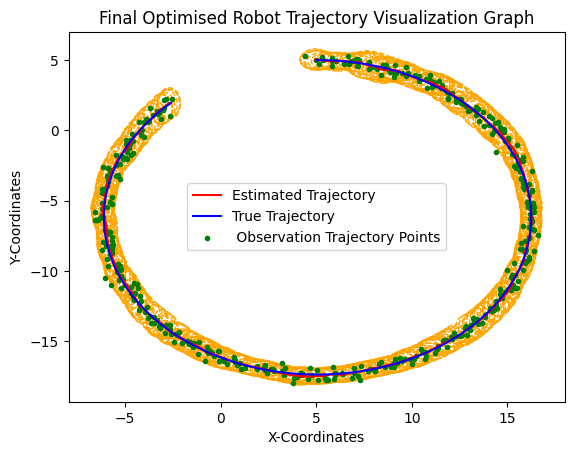

In [104]:
# Run the run_ekf() function
x_est, P_est = run_ekf()